## Program the FPGA (Don't do this if we already programmed the FPGA during GPS testing)

In [1]:
import subprocess
programFPGA = subprocess.run('quartus_pgm -m jtag -o "p;C:\\Users\Kwiat Lab\Desktop\FPGA Firmware\TX\FPGA Files\TX_FPGA_CL_082523.sof@2"', shell = True)
# programFPGA = subprocess.run('quartus_pgm -m jtag -o "p;C:\\Users\sanchez-rosales.1la\Desktop\TX\FPGA_files\FPGA_Programming_Files\TX_FPGA_CL_GPS_111323.sof@2"', shell = True)


## Setup FPGA ISMCE (Run this)

In [1]:
import mif
import quartustcl

quartus = quartustcl.QuartusTcl()
hwnames = quartus.parse(quartus.get_hardware_names())
hwname = hwnames[0]
devnames = quartus.parse(quartus.get_device_names(hardware_name=hwname))
devname = devnames[1]
memories_raw = quartus.get_editable_mem_instances(
    hardware_name=hwname, device_name=devname)

memories = quartus.parse(memories_raw, levels=2)

quartus.begin_memory_edit(hardware_name=hwname, device_name=devname)

nshifts = '0'
state_choice = '1'
direction_control = '2'
enable_sig_dec = '3'
enable_shifts = '4'

# nshifts = '2'
# state_choice = '3'
# direction_control = '4'
# enable_sig_dec = '5'
# enable_shifts = '6'

def write_to_mem(memid,value):
    if memid == '0':
        bin_value = '{0:08b}'.format(value)
    elif memid == '1':
        bin_value = '{0:03b}'.format(value)
    elif memid == '2' or memid == '3':
        bin_value = '{0:02b}'.format(value)
    else:
        bin_value = '{0:01b}'.format(value)

#     if memid == '2':
#         bin_value = '{0:08b}'.format(value)
#     elif memid == '3':
#         bin_value = '{0:03b}'.format(value)
#     elif memid == '4' or memid == '5':
#         bin_value = '{0:02b}'.format(value)
#     elif memid == '6':
#         bin_value = '{0:01b}'.format(value)

    quartus.write_content_to_memory(
        content = bin_value,
        instance_index = memid,
        start_address= 0,
        word_count=1,
    )
    return 1

In [2]:
memories


[['0', '1', '8', 'RW', 'ROM/RAM', 'SHFT'],
 ['1', '1', '3', 'RW', 'ROM/RAM', 'CRAM'],
 ['2', '1', '2', 'RW', 'ROM/RAM', 'SW12'],
 ['3', '1', '2', 'RW', 'ROM/RAM', 'SW89'],
 ['4', '1', '1', 'RW', 'ROM/RAM', 'ENAB']]

## Turn On Signals and Decoys

In [3]:
write_to_mem(enable_sig_dec,3)
# Argument number
#   0 - All off
#   1 - Signal Only
#   2 - Decoy Only
#   3 - Signal + Decoy

1

## Setup TimeTagger

In [4]:
from TimeTagger import *
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import *
def log_handler(level, msg):
    if level >= LOGGER_WARNING:
        print(msg)
def time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time, file_to_save):
    # activate trivial custom logging
    setLogger(log_handler)
    # create a timetagger instance
    tagger = createTimeTagger()
    tagger.reset()
    
    count = TimeDifferences(tagger, click_channel, start_channel, binwidth=binwidth, n_bins=n_bins) # 5 is slow
    pause(pause_time)
    
    count_y = np.array(count.getData())[0]
    count_x = count.getIndex()/1e3
    
    max_index = np.where(count_y==np.max(count_y))[0][0]
    start = max_index-100
    end = max_index+100

    plt.plot(count_x[start:end],count_y[start:end])
    
    
    with open(file_to_save + '.npy', 'wb') as f:
        np.save(f, count_y, allow_pickle=True)
        np.save(f, count_x, allow_pickle=True)
    
    return count_y, count_x

def fft_check(data, setpoint):
    
    fourier_overlap = np.real(np.fft.irfft(np.conj(np.fft.rfft(data))*np.fft.rfft(setpoint)))
    shift = int(np.where(fourier_overlap==np.max(fourier_overlap))[0][0])
    
    if shift>(n_bins/2):
        shift = shift-n_bins

    return shift

## Colllect Setpoint Data (Don't run this for normal temporal compensation)

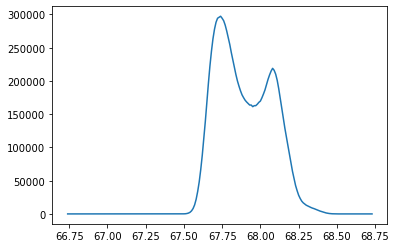

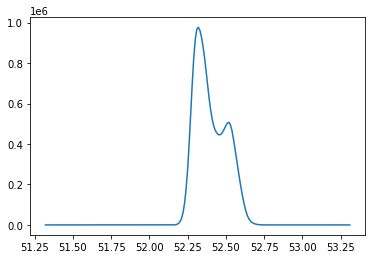

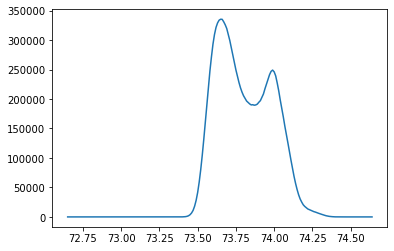

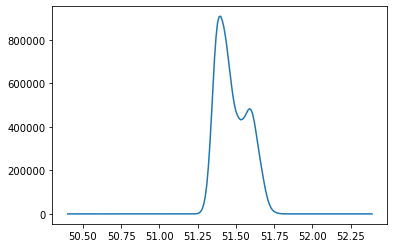

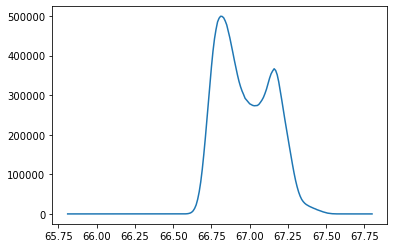

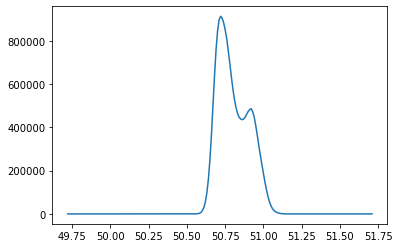

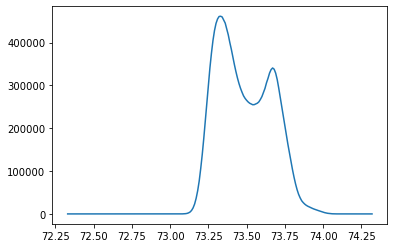

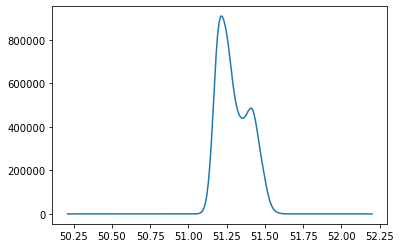

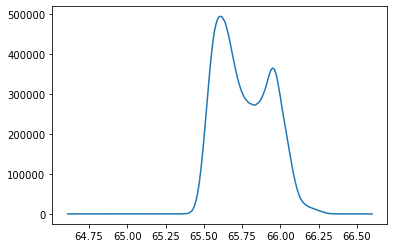

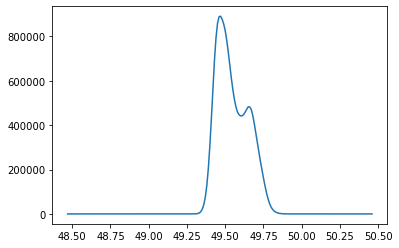

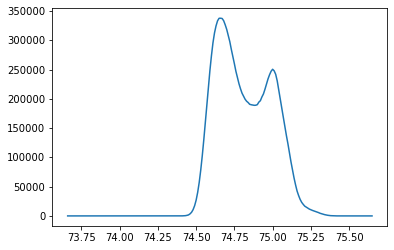

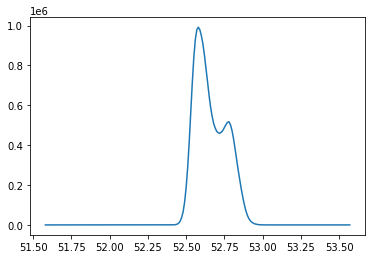

In [53]:
click_channel = 1
start_channel = 5
binwidth = int(1e1)
n_bins=int(80*1e3/binwidth)
pause_time = 1

states = ['sigR', 'decR', 'sigL', 'decL', 'sigH', 'decH']
today_date = '2023-12-08'

write_to_mem(enable_sig_dec,3)

for i in range(6):
    setpoint_posedge_file = states[i] + '_setpoint_posedge_LKH_' + today_date
    setpoint_negedge_file = states[i] + '_setpoint_negedge_LKH_' + today_date

    write_to_mem(state_choice,i)

    time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time, setpoint_posedge_file)
    time_data_aq(click_channel, -start_channel, binwidth, n_bins, pause_time, setpoint_negedge_file)
    

## Temporal Compensation Functions

In [5]:
def temporal_compensation_shift(state, click_channel, start_channel, binwidth, n_bins, pause_time, file_to_load, file_to_save):
    
    write_to_mem(enable_sig_dec,3)
    write_to_mem(state_choice,state)
    
    with open(file_to_load + '.npy', 'rb') as f:
        setpoint_y = np.load(f)
        setpoint_x = np.load(f)
    
    while True:
        hist_data = time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time,file_to_save)
        shift = fft_check(hist_data[0], setpoint_y)
        n_shifts = round(2*shift*binwidth/78)
        print("the index is: ", shift)
        print("the number of shifts is: ", n_shifts)

        
        if np.abs(shift) < 5:
            print("shift compensation within tolerance: ", n_shifts, " ns")
            print("##########################################################################")
            break
            
        else:
            print("shift compensation not achieved: ", n_shifts, " ns")
 
            
            print("##########################################################################")
            
            if n_shifts > 255:
                n_shifts = 255
            elif n_shifts < -255:
                n_shifts = -255
    
            write_to_mem(nshifts,int(abs(n_shifts)))
            
            if n_shifts < 0:
                write_to_mem(direction_control, 3)
                write_to_mem(enable_shifts, 1)
                write_to_mem(enable_shifts, 0)
                
            elif n_shifts > 0: 
                write_to_mem(direction_control, 2)
                write_to_mem(enable_shifts, 1)
                write_to_mem(enable_shifts, 0)
    
    index_setpoint = np.where(setpoint_y == np.max(setpoint_y))[0][0]
    index_data = np.where(hist_data[0] == np.max(hist_data[0]))[0][0]
    
    print(index_setpoint,index_data)
    
    window = 100
    plt.plot(setpoint_x[index_setpoint-window:index_setpoint+window],setpoint_y[index_setpoint-window:index_setpoint+window])
    plt.plot(hist_data[1][index_data-window:index_data+window],hist_data[0][index_data-window:index_data+window])
    plt.show()
    
    return hist_data

def temporal_compensation_width(state, click_channel, start_channel, binwidth, n_bins, pause_time, file_to_load, file_to_save):
    
    write_to_mem(enable_sig_dec,3)
    write_to_mem(state_choice,state)
    
    with open(file_to_load + '.npy', 'rb') as f:
        setpoint_y = np.load(f)
        setpoint_x = np.load(f)
    
    while True:
        hist_data = time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time,file_to_save)
        shift = fft_check(hist_data[0], setpoint_y)
        n_shifts = round(2*shift*binwidth/78)
        print("the index is: ", shift)
        print("the number of shifts is: ", n_shifts)

        
        if np.abs(shift) < 5:
            print("width compensation within tolerance: ", n_shifts, " ns")
            print("##########################################################################")
            break
            
        else:
            print("width compensation not achieved: ", n_shifts, " ns")
 
            
            print("##########################################################################")
            
            if n_shifts > 255:
                n_shifts = 255
            elif n_shifts < -255:
                n_shifts = -255
    
            write_to_mem(nshifts,int(abs(n_shifts)))
            
            if n_shifts < 0:
                write_to_mem(direction_control, 1)
                write_to_mem(enable_shifts, 1)
                write_to_mem(enable_shifts, 0)
                
            elif n_shifts > 0: 
                write_to_mem(direction_control, 0)
                write_to_mem(enable_shifts, 1)
                write_to_mem(enable_shifts, 0)
    
    index_setpoint = np.where(setpoint_y == np.max(setpoint_y))[0][0]
    index_data = np.where(hist_data[0] == np.max(hist_data[0]))[0][0]
    
    print(index_setpoint,index_data)
    window=100
    plt.plot(setpoint_x[index_setpoint-window:index_setpoint+window],setpoint_y[index_setpoint-window:index_setpoint+window])
    plt.plot(hist_data[1][index_data-window:index_data+window],hist_data[0][index_data-window:index_data+window])
    plt.show()
    
    return hist_data

def temporal_compensation(state, click_channel, start_channel, binwidth, n_bins, pause_time, load_posedge_file, save_posedge_file, load_negedge_file, save_negedge_file):
    negedge_data = temporal_compensation_shift(state, click_channel, start_channel, binwidth, n_bins, pause_time, load_posedge_file, save_posedge_file)
    posedge_data = temporal_compensation_width(state, click_channel, -start_channel, binwidth, n_bins, pause_time, load_negedge_file, save_negedge_file)
    negedge_data = temporal_compensation_shift(state, click_channel, start_channel, binwidth, n_bins, pause_time, load_posedge_file, save_posedge_file)
    return posedge_data, negedge_data

## Make a Width Adjustment (Skip this when performing temporal compensation)

In [36]:
write_to_mem(state_choice,0)
write_to_mem(nshifts,4)
write_to_mem(direction_control, 0)
write_to_mem(enable_shifts, 1)
write_to_mem(enable_shifts, 0)

1

## Make a Shift Adjustment (Skip this when performing temporal compensation)

In [16]:
write_to_mem(state_choice,0)
write_to_mem(nshifts,32)
write_to_mem(direction_control, 3)
write_to_mem(enable_shifts, 1)
write_to_mem(enable_shifts, 0)

1

## Perform both shift and width control (Skip this when performing temporal compensation)

In [11]:
for j in range(2):
    for k in range(6):
        write_to_mem(state_choice,k)
        write_to_mem(nshifts,255)
        write_to_mem(direction_control, 1)
        write_to_mem(enable_shifts, 1)
        write_to_mem(enable_shifts, 0)
        
        write_to_mem(state_choice,k)
        write_to_mem(nshifts,128)
        write_to_mem(direction_control, 2)
        write_to_mem(enable_shifts, 1)
        write_to_mem(enable_shifts, 0)

## Perform Temporal Compensation

the index is:  2938
the number of shifts is:  753
shift compensation not achieved:  753  ns
##########################################################################


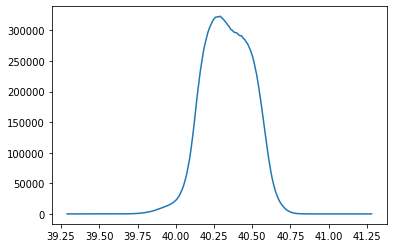

the index is:  1939
the number of shifts is:  497
shift compensation not achieved:  497  ns
##########################################################################


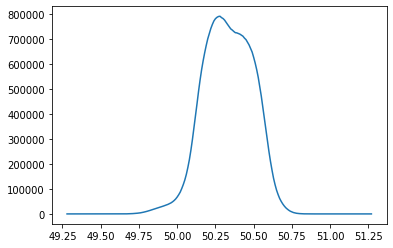

the index is:  939
the number of shifts is:  241
shift compensation not achieved:  241  ns
##########################################################################


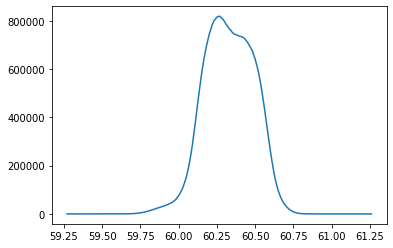

the index is:  -8
the number of shifts is:  -2
shift compensation not achieved:  -2  ns
##########################################################################


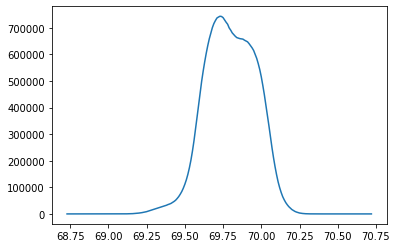

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6988 6964


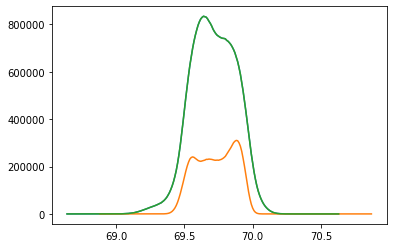

the index is:  2350
the number of shifts is:  603
width compensation not achieved:  603  ns
##########################################################################


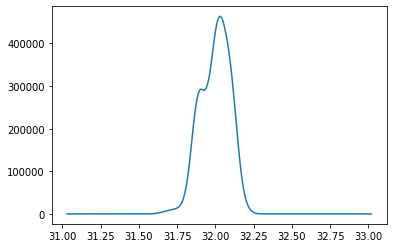

the index is:  1350
the number of shifts is:  346
width compensation not achieved:  346  ns
##########################################################################


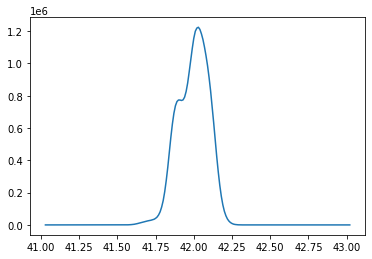

the index is:  349
the number of shifts is:  89
width compensation not achieved:  89  ns
##########################################################################


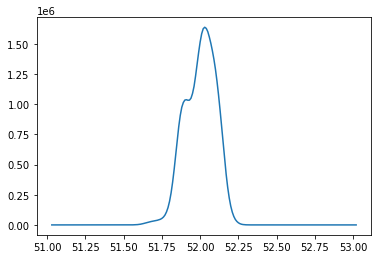

the index is:  -3
the number of shifts is:  -1
width compensation within tolerance:  -1  ns
##########################################################################
5543 5555


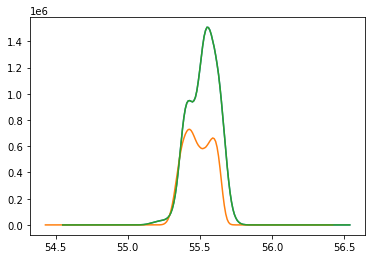

the index is:  1
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6988 6963


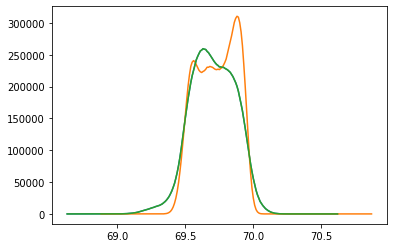

the index is:  194
the number of shifts is:  50
shift compensation not achieved:  50  ns
##########################################################################


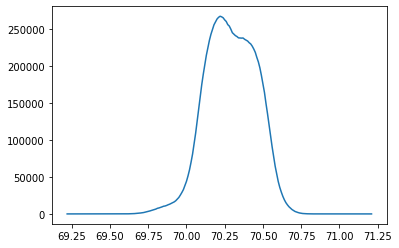

the index is:  -1
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
7240 7217


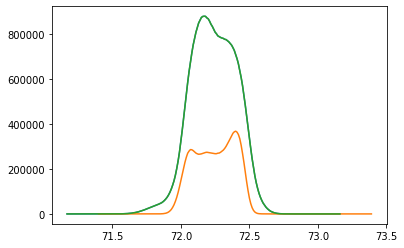

the index is:  1625
the number of shifts is:  417
width compensation not achieved:  417  ns
##########################################################################


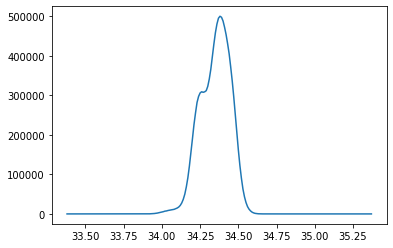

the index is:  624
the number of shifts is:  160
width compensation not achieved:  160  ns
##########################################################################


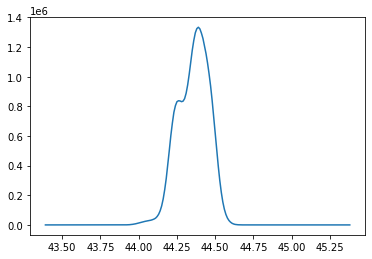

the index is:  -2
the number of shifts is:  -1
width compensation within tolerance:  -1  ns
##########################################################################
5053 5065


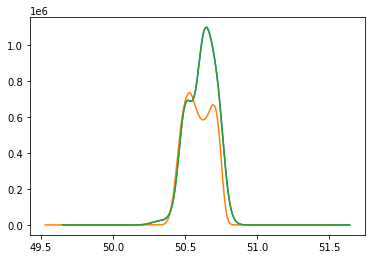

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
7240 7216


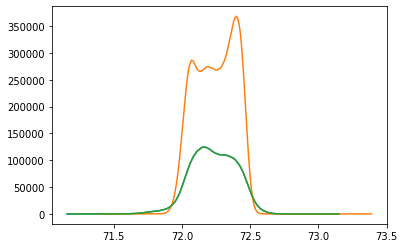

the index is:  -280
the number of shifts is:  -72
shift compensation not achieved:  -72  ns
##########################################################################


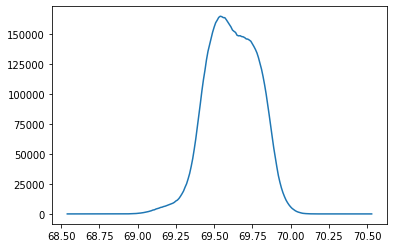

the index is:  2
the number of shifts is:  1
shift compensation within tolerance:  1  ns
##########################################################################
6699 6673


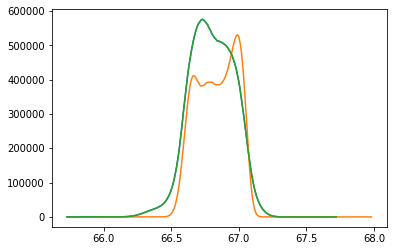

the index is:  2222
the number of shifts is:  570
width compensation not achieved:  570  ns
##########################################################################


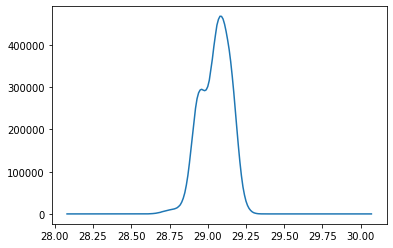

the index is:  1222
the number of shifts is:  313
width compensation not achieved:  313  ns
##########################################################################


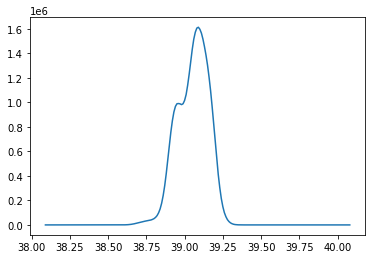

the index is:  221
the number of shifts is:  57
width compensation not achieved:  57  ns
##########################################################################


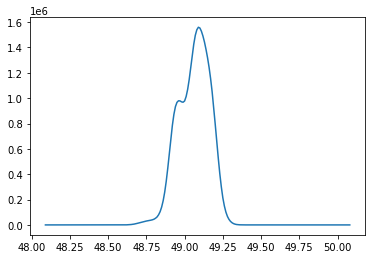

the index is:  -3
the number of shifts is:  -1
width compensation within tolerance:  -1  ns
##########################################################################
5120 5133


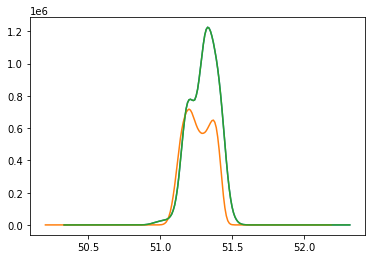

the index is:  3
the number of shifts is:  1
shift compensation within tolerance:  1  ns
##########################################################################
6699 6672


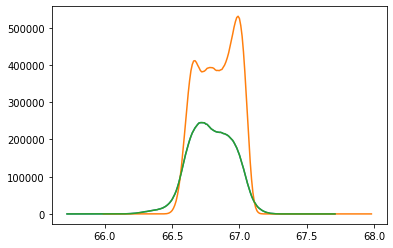

the index is:  563
the number of shifts is:  144
shift compensation not achieved:  144  ns
##########################################################################


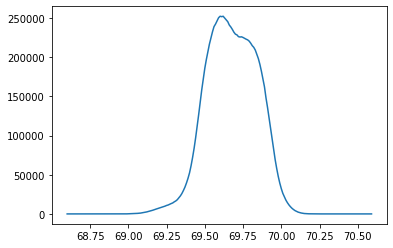

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
7546 7524


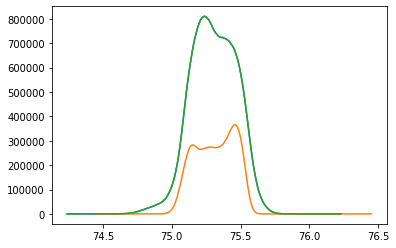

the index is:  1624
the number of shifts is:  416
width compensation not achieved:  416  ns
##########################################################################


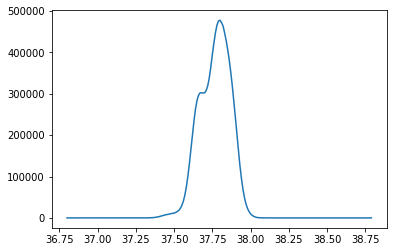

the index is:  623
the number of shifts is:  160
width compensation not achieved:  160  ns
##########################################################################


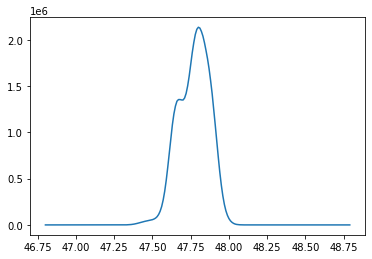

the index is:  0
the number of shifts is:  0
width compensation within tolerance:  0  ns
##########################################################################
5394 5403


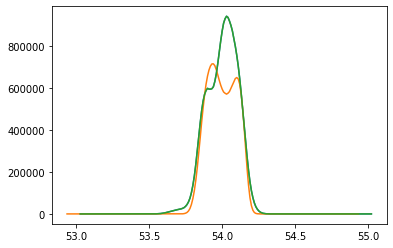

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
7546 7523


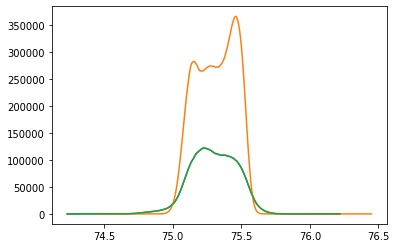

the index is:  87
the number of shifts is:  22
shift compensation not achieved:  22  ns
##########################################################################


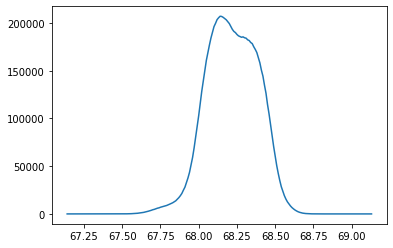

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6925 6903


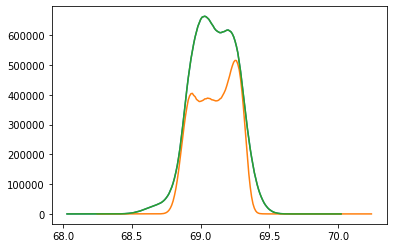

the index is:  2305
the number of shifts is:  591
width compensation not achieved:  591  ns
##########################################################################


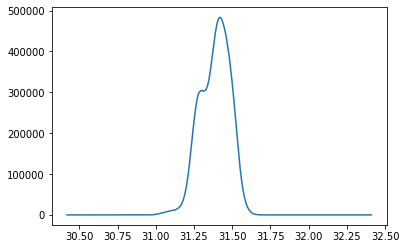

the index is:  1307
the number of shifts is:  335
width compensation not achieved:  335  ns
##########################################################################


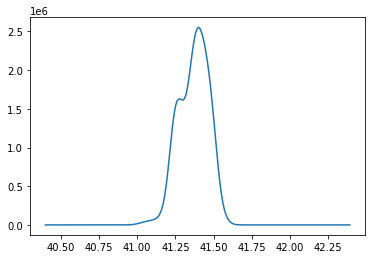

the index is:  311
the number of shifts is:  80
width compensation not achieved:  80  ns
##########################################################################


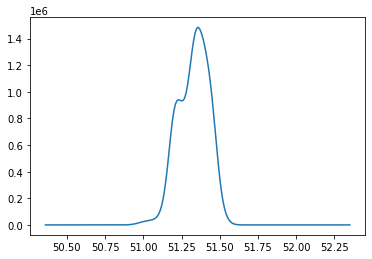

the index is:  -3
the number of shifts is:  -1
width compensation within tolerance:  -1  ns
##########################################################################
5438 5450


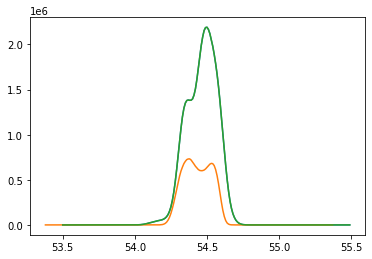

the index is:  1
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6925 6902


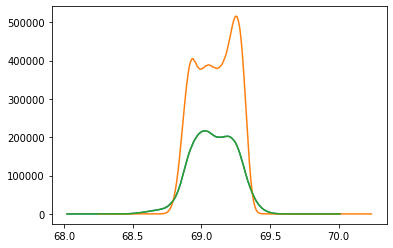

the index is:  341
the number of shifts is:  87
shift compensation not achieved:  87  ns
##########################################################################


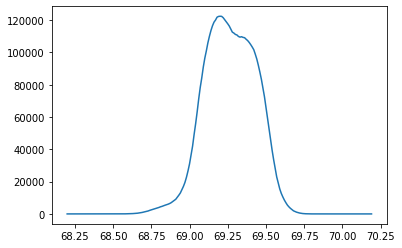

the index is:  1
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
7285 7260


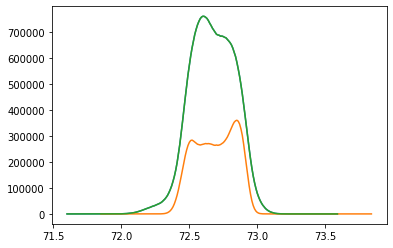

the index is:  1573
the number of shifts is:  403
width compensation not achieved:  403  ns
##########################################################################


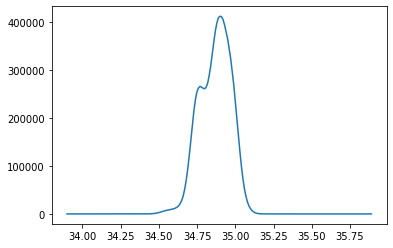

the index is:  572
the number of shifts is:  147
width compensation not achieved:  147  ns
##########################################################################


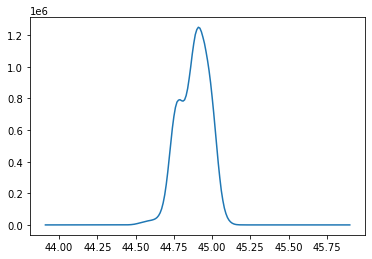

the index is:  -7
the number of shifts is:  -2
width compensation not achieved:  -2  ns
##########################################################################


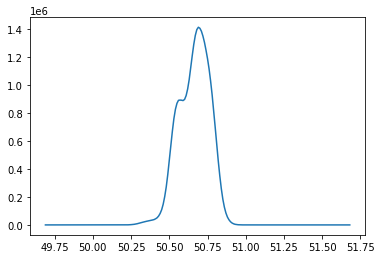

the index is:  2
the number of shifts is:  1
width compensation within tolerance:  1  ns
##########################################################################
5053 5061


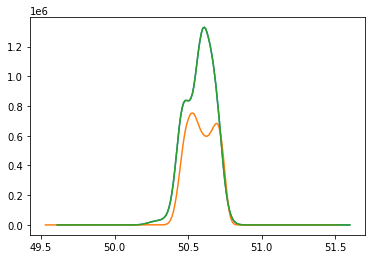

the index is:  2
the number of shifts is:  1
shift compensation within tolerance:  1  ns
##########################################################################
7285 7260


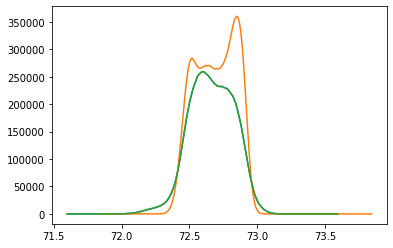

11-Dec-2023 17:58:51: Time Tagger '1947000S7B' disconnected because of an USB error. Got the USB error 'Failed' in 'ReadFromBlockPipeOut' in line 1070. (TimeTaggerImpl.cpp:1409)


In [8]:
click_channel = 1 #J27 connector on HSCM daughter card
start_channel = 3 #J25 connector on HSCM daughter card
binwidth = int(1e1)
n_bins=int(80*1e3/binwidth)
pause_time = 1

states = ['sigR', 'decR', 'sigL', 'decL', 'sigH', 'decH']
today_date = '2023-12-11' #Enter today's date!
comparison_date = '2023-08-25'

write_to_mem(enable_sig_dec,3)

for i in range(6):
    load_posedge_file = states[i] + '_setpoint_posedge_CL_' + comparison_date
    load_negedge_file = states[i] + '_setpoint_negedge_CL_' + comparison_date
    
    save_posedge_file = states[i] + '_comp_posedge_' + today_date
    save_negedge_file = states[i] + '_comp_negedge_' + today_date
    
    temporal_compensation(i, click_channel, start_channel, binwidth, n_bins, pause_time, load_posedge_file, save_posedge_file, load_negedge_file, save_negedge_file)

# END OF CODE

## Test Area

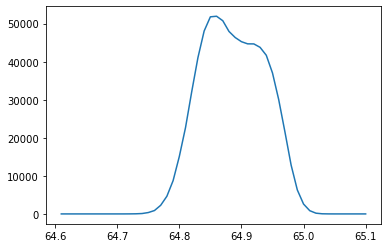

In [388]:
click_channel = 1
start_channel = 5
binwidth = int(1e1)
n_bins=int(80*1e3/binwidth)
pause_time = 1
today_date = '2022-10-07'
setpoint_data_filename = 'decLtest_setpoint_posedge_' + today_date

write_to_mem(state_choice,3)

setpoint_data = time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time, setpoint_data_filename )


filename = setpoint_data_filename
with open(filename + '.npy', 'rb') as f:
        y = np.load(f)
        x = np.load(f)
max_index = np.where(y==np.max(y))[0][0]
start = max_index-25
end = max_index+25

plt.plot(x[start:end],y[start:end])

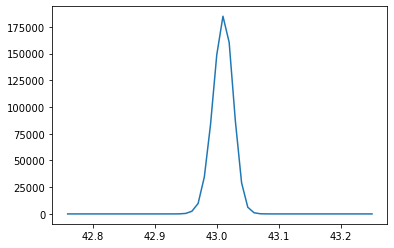

In [389]:
click_channel = 1
start_channel = -5
binwidth = int(1e1)
n_bins=int(80*1e3/binwidth)
pause_time = 1
today_date = '2022-10-07'
setpoint_data_filename = 'decLtest_setpoint_negedge_' + today_date

write_to_mem(state_choice,3)

setpoint_data = time_data_aq(click_channel, start_channel, binwidth, n_bins, pause_time, setpoint_data_filename )


filename = setpoint_data_filename
with open(filename + '.npy', 'rb') as f:
        y = np.load(f)
        x = np.load(f)
max_index = np.where(y==np.max(y))[0][0]
start = max_index-25
end = max_index+25

plt.plot(x[start:end],y[start:end])

the index is:  -779
the number of shifts is:  -200
shift compensation not achieved:  -200  ns
##########################################################################
the index is:  -7
the number of shifts is:  -2
shift compensation not achieved:  -2  ns
##########################################################################
the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6486 6486


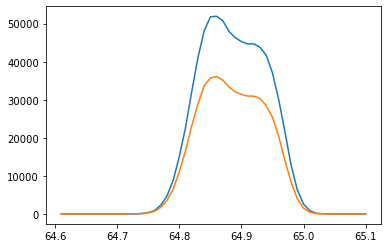

the index is:  1030
the number of shifts is:  264
width compensation not achieved:  264  ns
##########################################################################
the index is:  587
the number of shifts is:  151
width compensation not achieved:  151  ns
##########################################################################
the index is:  -16
the number of shifts is:  -4
width compensation not achieved:  -4  ns
##########################################################################
the index is:  0
the number of shifts is:  0
width compensation within tolerance:  0  ns
##########################################################################
4301 4302


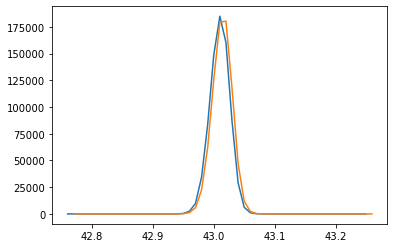

the index is:  0
the number of shifts is:  0
shift compensation within tolerance:  0  ns
##########################################################################
6486 6486


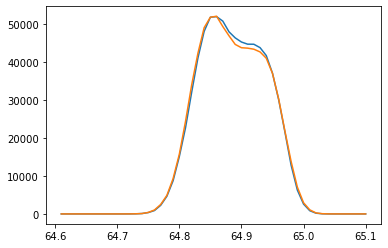

In [396]:
click_channel = 1
start_channel = 5
binwidth = int(1e1)
n_bins=int(80*1e3/binwidth)
pause_time = 1

states = ['decLtest']
today_date = '2022-10-07'

write_to_mem(enable_sig_dec,3)
for i in range(1):
    
    load_posedge_file = states[i] + '_setpoint_posedge_' + today_date
    load_negedge_file = states[i] + '_setpoint_negedge_' + today_date
    
    save_posedge_file = states[i] + '_comp_posedge_' + today_date
    save_negedge_file = states[i] + '_comp_negedge_' + today_date
    i=3
    
    temporal_compensation(i, click_channel, start_channel, binwidth, n_bins, pause_time, load_posedge_file, save_posedge_file, load_negedge_file, save_negedge_file)

In [3]:
import mif
import quartustcl

quartus = quartustcl.QuartusTcl()
hwnames = quartus.parse(quartus.get_hardware_names())
hwname = hwnames[0]
devnames = quartus.parse(quartus.get_device_names(hardware_name=hwname))
devname = devnames[1]
memories_raw = quartus.get_editable_mem_instances(
    hardware_name=hwname, device_name=devname)

memories = quartus.parse(memories_raw, levels=2)

quartus.begin_memory_edit(hardware_name=hwname, device_name=devname)


''

# Setpoint for Optical Temporal Compensation

2023-08-26 14:13:55.062053
1118823.4


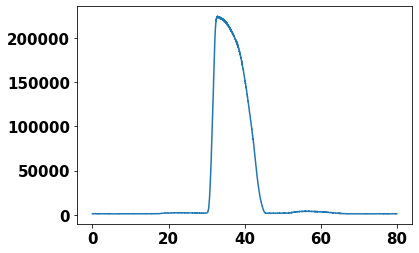

percent overlapped:  0.9736099175161333
0.9996573770654189
data_1 (green) should be moved  -0.22  ns. ( -0x6 )
FWHM_1 =  9.88  ns. ( 0x3 )
0.9867012078051405
4.10643287545743
FWHM_2 =  10.04  ns


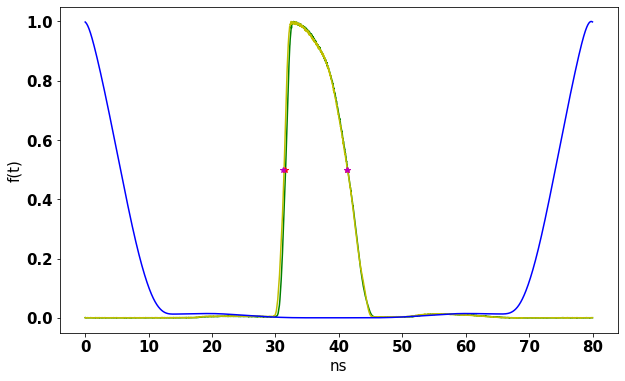

(-220, 9880.0, 0.9736099175161333, 1070082.4399999997, 4.10643287545743, 9.88)

In [78]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 19 11:47:25 2021
@author: danis
"""
from TimeTagger import setLogger, createTimeTagger, Combiner, Coincidence, Counter, Countrate, Correlation, TimeDifferences, StartStop, TimeTagStream, Scope, Event, CHANNEL_UNUSED, UNKNOWN, LOW, HIGH, LOGGER_WARNING
from pylab import *
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import datetime
now = str(datetime.datetime.now())
print(now)
def log_handler(level, msg):
    if level >= LOGGER_WARNING:
        print(msg)
state_str = 'sigH'
pause_time = 100
def time_data_aq(state_str,pause_time):
    # activate trivial custom logging
    setLogger(log_handler)
    # create a timetagger instance
    tagger = createTimeTagger()
    tagger.reset()
    #tagger.setConditionalFilter(trigger=[4],filtered=[1])
    binwidth = int(2e1)
    n_bins=int(80*1e3/binwidth)
    count = TimeDifferences(tagger, 1, 5, binwidth=binwidth, n_bins=n_bins) # 5 is slow
    pause(pause_time)
    data_1 = np.array(count.getData())[0]
    data_sub = np.zeros(np.shape(data_1))
    new_start = int(-7*1e3/binwidth)%n_bins
    data_sub[:(n_bins-new_start)] = data_1[new_start:]
    data_sub[(n_bins-new_start):] = data_1[:new_start]
    del data_1
    data_1 = data_sub
    #print(data_1)
    print(sum(data_1)/pause_time)
    figure()
    plot(count.getIndex()/1e3, data_1)
    show()
    #change the file name for new data sets
    sent_data_map = np.memmap('timing_data/'+state_str+'_'+str(pause_time)+'s_'+now[:10]+'_10ns_LKH_test.npy', dtype='float32', mode='w+', shape=(n_bins))
    sent_data_map[:] = data_1.T
    del sent_data_map
    #keep this file name the same: that of the data set we are comparing to
    received_data_map = np.memmap('timing_data/sigR_100s_2023-08-26_10ns_LKH.npy',dtype='float32',offset = 0,shape=(n_bins))
    data_2 = np.array(received_data_map.T)
    del received_data_map
    dt=80/n_bins
    #data_2=data_1
    data_1 = data_1 - np.ones(n_bins)*np.mean(data_1[:int(10*10**3/binwidth)])
    data_2 = data_2 - np.ones(n_bins)*np.mean(data_2[:int(10*10**3/binwidth)])
    integ1 = np.sum(data_1[:-1]+data_1[1:])*dt/2
    integ2 = np.sum(data_2[:-1]+data_2[1:])*dt/2
    over_integ = np.sum(np.abs((data_1[:-1]+data_1[1:])/integ1-(data_2[:-1]+data_2[1:])/integ2))*dt/2
    print('percent overlapped: ',1-over_integ/2)
    fourier_overlap = np.real(np.fft.irfft(np.conj(np.fft.rfft(data_1))*np.fft.rfft(data_2)))
    fig_true = plt.figure(figsize=(10,6))
    ax_true = fig_true.add_subplot(1,1,1)
    ax_true.plot(np.array(range(len(data_1)))*binwidth*1e-3,data_1/np.max(data_1),'g')
    ax_true.plot(np.array(range(len(data_2)))*binwidth*1e-3,data_2/np.max(data_2),'y')
    ax_true.plot(np.array(range(len(fourier_overlap)))*binwidth*1e-3,fourier_overlap/np.max(fourier_overlap),'b')
    plt.xlabel('ns')
    plt.ylabel('f(t)')
    shift = int(np.where(fourier_overlap==np.max(fourier_overlap))[0][0])
    if shift>(n_bins/2):
        shift = shift-n_bins
    print(2*np.sum(data_1)*np.sum(data_2)*np.max(fourier_overlap)/(np.sum(data_2)**2*np.sum(data_1**2)+np.sum(data_1)**2*np.sum(data_2**2)))
    print('data_1 (green) should be moved ',shift*binwidth*1e-3,' ns. (',hex(round(shift*binwidth/78*2)),')')
    #shift_num = (round(shift*binwidth/78)*2)
    shift_num = shift*binwidth
    halfmax = (np.max(data_1)+np.min(data_1))/2
    #print(halfmax)
    pt_1=[0]
    tol = (halfmax - np.min(data_1))*.2
    for i in range(data_1.shape[0]):
        if ((np.abs(data_1[i]-halfmax)<tol) & ((i-pt_1[-1])>30)):
            pt_1.append(i)
    diff_pt_1 = np.diff(pt_1[1:])
    breaker = np.where(diff_pt_1==np.max(diff_pt_1))[0][0]
    #print(breaker)
    pt1_av = []
    pt1_av.append(np.mean(pt_1[1:breaker+2]))
    pt1_av.append(np.mean(pt_1[breaker+2:]))
    print('FWHM_1 = ',(pt1_av[1]-pt1_av[0])*binwidth/1000,' ns. (',hex(round((10*1e3-(pt1_av[1]-pt1_av[0])*binwidth)/78*2)),')')
    ax_true.plot(np.array(pt1_av)*binwidth/1000,np.array([halfmax,halfmax])/np.max(data_1),'*',color='r')
    #width_num = (round((10*1e3-(pt1_av[1]-pt1_av[0])*binwidth)/78)*2)
    width_num = (pt1_av[1]-pt1_av[0])*binwidth
    halfmax = (np.max(data_2)+np.min(data_2))/2
    #print(halfmax)
    pt_2=[0]
    tol = (halfmax - np.min(data_2))*.2
    for i in range(data_2.shape[0]):
        if ((np.abs(data_2[i]-halfmax)<tol) & ((i-pt_2[-1])>30)):
            pt_2.append(i)
    diff_pt_2 = np.diff(pt_2[1:])
    breaker = np.where(diff_pt_2==np.max(diff_pt_2))[0][0]
    pt2_av = []
    pt2_av.append(np.mean(pt_2[1:breaker+2]))
    pt2_av.append(np.mean(pt_2[breaker+2:]))
    data_sub = np.zeros(np.shape(data_1))
    shift=(-shift)%n_bins
    #print(data_sub[:(n_bins-shift)].shape,n_bins,shift)
    data_sub[:(n_bins-shift)] = data_1[shift:]
    data_sub[(n_bins-shift):] = data_1[:shift]
    integ1 = np.sum(data_sub[:-1]+data_sub[1:])*dt/2
    integ2 = np.sum(data_2[:-1]+data_2[1:])*dt/2
    opt_integ = np.sum(np.abs((data_sub[:-1]+data_sub[1:])/integ1-(data_2[:-1]+data_2[1:])/integ2))*dt/2
    print(1-opt_integ/2)
    data_1_mu = np.sum(data_1/np.sum(data_1)*(np.array(range(len(data_1)))*binwidth*1e-3))
    data_1_std = np.sqrt(np.sum(data_1/np.sum(data_1)*(np.array(range(len(data_1)))*binwidth*1e-3-data_1_mu)**2))
    print(data_1_std)
    print('FWHM_2 = ',(pt2_av[1]-pt2_av[0])*binwidth/1000,' ns')
    ax_true.plot(np.array(pt2_av)*binwidth/1000,np.array([halfmax,halfmax])/np.max(data_2),'*',color='m')
    plt.show()
    return shift_num,width_num,1-over_integ/2,sum(data_1)/pause_time,data_1_std,(pt1_av[1]-pt1_av[0])*binwidth/1000
time_data_aq(state_str,pause_time)

In [76]:
write_to_mem(enable_sig_dec,1)

1

# Optical Temporal Compensation

1070415.58


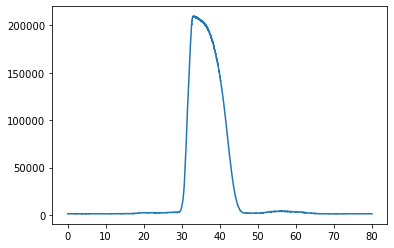

percent overlapped:  0.9814704289404449
0.9991200033983014
data_1 (green) should be moved  -0.12  ns. ( -0x3 )
FWHM_1 =  9.83  ns. ( 0x4 )
0.9822471030544017
4.161294840920868
FWHM_2 =  10.04  ns


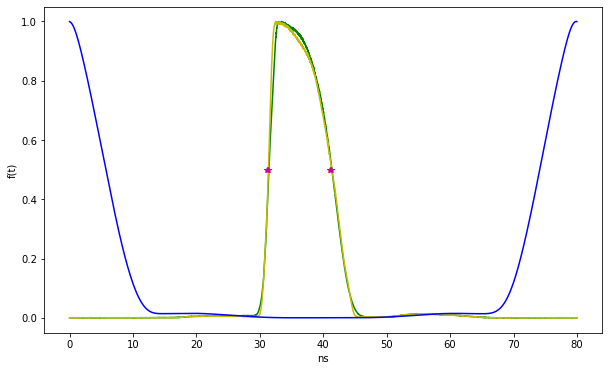

-120 9830.0
1095539.78


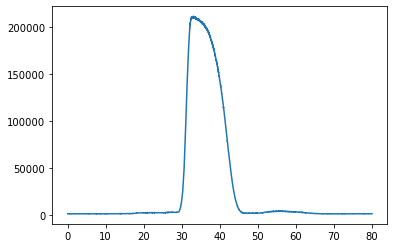

percent overlapped:  0.9760218205240205
0.9995715935595425
data_1 (green) should be moved  0.2  ns. ( 0x5 )
FWHM_1 =  9.91  ns. ( 0x2 )
0.9872424514301339
4.190841567355243
FWHM_2 =  10.04  ns


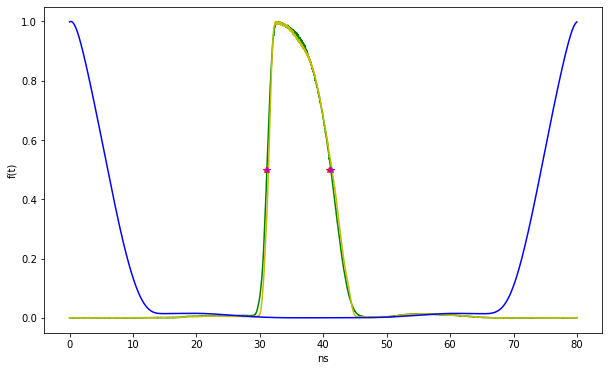

200 9910.0
1109339.3


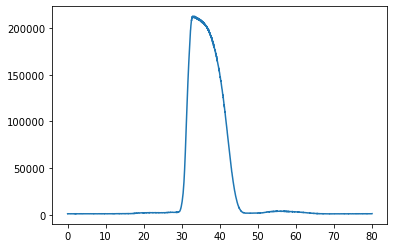

percent overlapped:  0.9848266522558912
0.999294371236568
data_1 (green) should be moved  0.0  ns. ( 0x0 )
FWHM_1 =  9.99  ns. ( 0x0 )
0.9848266522558912
4.207754759467027
FWHM_2 =  10.04  ns


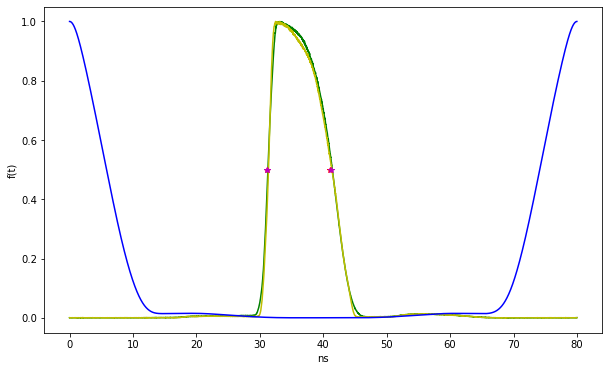

Good overlap achieved
0 9990.0
0 9990.0
Shifting complete
['+4', '+2']
['-4', '+6']


In [51]:
#iteratively measure and adjust temporal alignment
#import pydirectinput
import time
state_str = 'decR'
pause_time = 100
abort=0
cnt=0
width_rec=[]
shift_rec=[]
if state_str=='sigR':
    cram = '0'
if state_str=='sigL':
    cram = '2'
if state_str=='sigH':
    cram = '4'
if state_str=='decR':
    cram = '1'
if state_str=='decL':
    cram = '3'
if state_str=='decH':
    cram = '5'

write_to_mem(state_choice,int(cram))

if state_str[:3] == 'dec':
    write_to_mem(enable_sig_dec,2)
else:
    write_to_mem(enable_sig_dec,1)
while abort==0:
    new_shift_num,new_width_num,new_overlap,data_rate,my_std,fwhm=time_data_aq(state_str,pause_time)
    cnt=cnt+1
    if new_overlap>(.992-(.01*(state_str[0]=='d'))):
        abort=1
        my_string = 'good overlap achieved'
        print('Good overlap achieved')
    print(new_shift_num,new_width_num)
    if ((abs(new_shift_num)<=50) and (abs(10e3-new_width_num)<=50)):
        print(new_shift_num,new_width_num)
        abort=1
        my_string = 'shifting complete'
        print('Shifting complete')
    if cnt>5:
        abort=1
        my_string = 'runtime: did not converge'
        print('Runtime: did not converge')
    if data_rate>35e5:
        abort=1
        my_string = 'someone turned on the lights?'
        print('Someone turned on the lights?')
    if (abs(new_width_num)>50 and abort==0):
        #width_rec.append(new_width_num)
        if np.sign(10e3-new_width_num)>0:
            write_to_mem(direction_control, 1)
            sign_mark = '+'
        else:
            write_to_mem(direction_control, 0)
            sign_mark = '-'
        my_hex = min([int(abs(np.round((10*1e3-new_width_num)/78)*2)),255])
        width_rec.append(sign_mark+str(my_hex))
        write_to_mem(nshifts,my_hex)
        write_to_mem(enable_shifts, 1)
        write_to_mem(enable_shifts, 0)
        
    if (abs(new_shift_num)>50 and abort==0):
        #shift_rec.append(new_shift_num)
        if np.sign(new_shift_num)>0:
            write_to_mem(direction_control, 2)
            sign_mark = '+'
        else:
            write_to_mem(direction_control, 3)
            sign_mark = '-'
        my_hex = min([int(abs(np.round(new_shift_num/78)*2)),255])
        
        shift_rec.append(sign_mark+str(my_hex))
        write_to_mem(nshifts,my_hex)
        write_to_mem(enable_shifts, 1)
        write_to_mem(enable_shifts, 0)
        
print(width_rec)
print(shift_rec)
np.save('timing_data/'+state_str+'_width_rec_'+str(pause_time)+'s_'+now[:10]+'_10ns.npy',width_rec)
np.save('timing_data/'+state_str+'_shift_rec_'+str(pause_time)+'s_'+now[:10]+'_10ns.npy',shift_rec)
#print(my_string)
#notify_mail(my_string)



# 4-Channel GUI

In [77]:
#import appJar
#cnt = 5
from appJar import gui
import time
from TimeTagger import setLogger, createTimeTagger, Combiner, Coincidence, Counter, Countrate, Correlation, TimeDifferences, StartStop, TimeTagStream, Scope, Event, CHANNEL_UNUSED, UNKNOWN, LOW, HIGH, LOGGER_WARNING
from pylab import *
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
def log_handler(level, msg):
    if level >= LOGGER_WARNING:
        print(msg)
# activate trivial custom logging
setLogger(log_handler)
# create a timetagger instance
#t0 = time.time()
# handle button events
def press1(button):
    if button == "Quit":
        app.stop()
def press2(button):
    if button == "Set Background":
        global background
        pause(5)
        background = np.array(count.getData())
def press3(button):
    if button == "Toggle Graph":
        global val
        val = 1-val
def updater():
    data1 = count.getData()
    data1 = (np.array(data1)-background)/(10**6)
    count.clear()
    #print(data1)
    #t1 = time.time()
    app.setLabel('R','R (MHz): '+str(round(data1[0],3)))
    app.setLabel('L','L (MHz): '+str(round(data1[1],3)))
    app.setLabel('H','H (MHz): '+str(round(data1[2],3)))
    app.setLabel('V','V (MHz): '+str(round(data1[3],3)))
    pol = app.getRadioButton("input")
    if pol == 'R':
        extrat = (data1[1]+data1[0])/data1[1]
        offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
        #theta = 90-np.arccos(np.sqrt(np.abs(1/extrat)))*360/(2*np.pi)
        theta = data1[1]+data1[0]+data1[2]+data1[3]
    if pol == 'L':
        extrat = (data1[0]+data1[1])/data1[0]
        offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
        #theta = 90-np.arccos(np.sqrt(np.abs(1/extrat)))*360/(2*np.pi)
        theta = data1[1]+data1[0]+data1[2]+data1[3]
    if pol == 'H':
        extrat = (data1[3]+data1[2])/data1[3]
        offbas = np.abs((data1[1]-data1[0])/(data1[1]+data1[0]))
        #theta = 90-np.arccos(np.sqrt(np.abs(1/extrat)))*360/(2*np.pi)
        theta = data1[1]+data1[0]+data1[2]+data1[3]
    global dat_arr
    dat_arr[:,:-1] = dat_arr[:,1:]
    dat_arr[:,-1] = np.array([extrat,offbas,theta,data1[0],data1[1],data1[2],data1[3]]).T
    app.setLabel("l", "Extinction ratio: "+str(round(extrat,3)))
    app.setLabel("2", "Off-basis matching: "+str(round(offbas,3)))
    app.setLabel("3", "Total counts: "+str(round(theta,3)))
    app.updatePlot('Extinction Ratio',np.arange(100),dat_arr[0+val*3,:])
    #showLabels('Extinction Ratio')
    app.updatePlot('Off-basis Ratio',np.arange(100),dat_arr[1+val*3,:])
    #showLabels('Extinction Ratio')
    app.updatePlot('Total counts',np.arange(100),dat_arr[2+val*3,:])
    #showLabels('Extinction Ratio')
    app.updatePlot('Extra',np.arange(100),dat_arr[3+val*3,:])
def showLabels(title):
    #axes.legend(['0'])
    ax1.set_title('Extinction Ratio')
    ax2.set_title('Off-basis Ratio')
    ax3.set_title('Total counts')
    #axes.set_ylabel("Y Axes")
    app.refreshPlot('Extinction Ratio')
    app.refreshPlot('Off-basis Ratio')
    app.refreshPlot('Total counts')
# create a GUI variable called app
#app.addMeter("progress")
tagger = createTimeTagger()
tagger.reset()
count = Countrate(tagger, [1,5,6,7])
app = gui("Multchannel sorting", "1100x600")
app.setBg("orange")
app.setFont(18)
#app.setStatusbar("Line: 20", 0)
#app.setStatusbar("Column: 4", 1)
#app.setStatusbar("Mode: Edit", 2)
# add & configure widgets - widgets get a name, to help referencing them later
app.startFrame("LEFT", row=1, column=1)
app.addLabel("title", "Polarization Recovery Tool")
app.setLabelBg("title", "blue")
app.setLabelFg("title", "orange")
app.addLabel("l", "Extinction ratio: ")
app.addLabel("2", "Off-basis matching: ")
app.addLabel("3", "Polarization: ")
#app.addLabelEntry("Username")
#app.addLabelSecretEntry("Password")
# link the buttons to the function called press
app.addButtons(["Quit"], press1)
app.addButtons(["Set Background"],press2)
app.addButtons(["Toggle Graph"],press3)
app.addRadioButton("input", "R")
app.addRadioButton("input", "L")
app.addRadioButton("input", "H")
app.stopFrame()
app.startFrame("RIGHTdown", row=1, column=2)
app.addLabel('R','R')
app.addLabel('L','L')
app.addLabel('H','H')
app.addLabel('V','V')
app.stopFrame()
dat_arr = np.zeros((7,100))
background = np.array([0,0,0,0])
val = 0
app.startFrame("RIGHT", row=1, column=0)
ax1 = app.addPlot('Extinction Ratio',np.arange(100),dat_arr[0,:])
#showLabels('Extinction Ratio')
ax2 = app.addPlot('Off-basis Ratio',np.arange(100),dat_arr[1,:])
ax3 = app.addPlot('Total counts',np.arange(100),dat_arr[2,:])
ax4 = app.addPlot('Extra',np.arange(100),dat_arr[2,:])
app.stopFrame()
#app.addStatusbar(fields=4,side="RIGHT")
app.registerEvent(updater)
#app.setFocus("Username")
# start the GUI
app.go()

C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp

C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp

C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp

C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp

C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp\1/ipykernel_7656/3239776.py:43: RuntimeWarning: invalid value encountered in double_scalars
  offbas = np.abs((data1[2]-data1[3])/(data1[3]+data1[2]))
C:\Users\SANCHE~1.1LA\AppData\Local\Temp

[[1.         0.99144292 0.96767386 0.98453138 0.98798009 0.98783712]
 [0.99144292 1.         0.96685476 0.97994003 0.98403581 0.98133146]
 [0.96767386 0.96685476 1.         0.96787344 0.96426756 0.95857383]
 [0.98453138 0.97994003 0.96787344 1.         0.9831923  0.98063696]
 [0.98798009 0.98403581 0.96426756 0.9831923  1.         0.99075375]
 [0.98783712 0.98133146 0.95857383 0.98063696 0.99075375 1.        ]]
0.9585738274384502


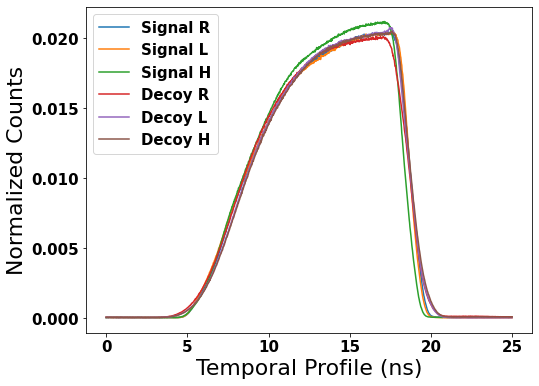

26-Aug-2023 14:19:21: Time Tagger '1947000S7D' disconnected because of an USB error. Got the USB error 'Failed' in 'ReadFromBlockPipeOut' in line 1275. (TimeTaggerImpl.cpp:1752)


In [79]:
import numpy as np
import matplotlib.pyplot as plt
filenames = ['sigR_100','sigL_100','sigH_100','decR_100','decL_100','decH_100']
#filenames = ['sigR_60','sigH_60','decL_60','decH_60']
legends = ['Signal R','Signal L','Signal H','Decoy R','Decoy L','Decoy H']
#legends = ['SignalRef','SignalMatch','DecoyRef','DecoyMatch']
#filenames = ['sigR']
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
date = '2023-08-26'
binwidth = int(2e1)
n_bins=int(80*1e3/binwidth)
indist = np.zeros([len(filenames),len(filenames)])
for i in range(len(filenames)):
    received_data_map = np.memmap('timing_data/'+filenames[i]+'s_'+date+'_'+'10ns_LKH_test.npy',dtype='float32',offset = 0,shape=(n_bins,1))
    data = np.array(received_data_map.T)[0]
    data = data - np.ones(n_bins)*np.mean(data[int(0*10**3/binwidth):int(10*10**3/binwidth)])
    del received_data_map
    b1 = int(25*10**3/binwidth)
    b2 = int(50*10**3/binwidth)
    ax.plot(np.array(range(len(data[b1:b2])))*binwidth*1e-3,
            np.flip(data[b1:b2])/(np.sum(data[b1:b2])*.1),label = legends[i])
    for j in range(len(filenames)):
        received_data_map2 = np.memmap('timing_data/'+filenames[j]+'s_'+date+'_'+'10ns_LKH_test.npy',dtype='float32',offset = 0,shape=(n_bins,1))
        data_comp = np.array(received_data_map2.T)[0]
        data_comp = data_comp - np.ones(n_bins)*np.mean(data_comp[int(0*10**3/binwidth):int(10*10**3/binwidth)])
        del received_data_map2
        dt=80/n_bins
        integ1 = np.sum(data[:-1]+data[1:])*dt/2
        integ2 = np.sum(data_comp[:-1]+data_comp[1:])*dt/2
        #print(integ1,integ2)
        over_integ = np.sum(np.abs((data[:-1]+data[1:])/integ1-(data_comp[:-1]+data_comp[1:])/integ2))*dt/2
        indist[i,j] = 1-over_integ/2
print(indist)
print(np.min(indist))
plt.xlabel('Temporal Profile (ns)', fontsize = 22)
plt.ylabel('Normalized Counts', fontsize = 22)
plt.legend()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)